In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from random import randint

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW, RMSprop
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.functional.classification.jaccard import jaccard_index

from copy import deepcopy

from colorama import Fore

from WeatherNet.weathernet import WeatherNet

from dataloader.dataset import WADS
from dataloader.dataloader import WADSLoader

# Dataset

In [3]:
train_ds = WADS("../wads_dataset/clean_dataset/Training/", do_projection=True, do_resize=False, size=(32, 512))
valid_ds = WADS("../wads_dataset/clean_dataset/Validation/", do_projection=True, do_resize=False, size=(32, 512))
test_ds = WADS("../wads_dataset/clean_dataset/Test/", do_projection=True, do_resize=False, size=(32, 512))

print("Number of training samples:", len(train_ds))
print("Number of validation samples:",len(valid_ds))
print("Number of test samples:",len(test_ds))

Number of training samples: 1316
Number of validation samples: 102
Number of test samples: 410


In [4]:
idx = 0
print(train_ds.scans[idx])
print(train_ds.labels[idx])

../wads_dataset/clean_dataset/Training/26/velodyne/041126.bin
../wads_dataset/clean_dataset/Training/26/labels/041126.label


In [5]:
proj_xyz, proj_range, proj_remission, label = train_ds[0]
print(proj_xyz.shape)
print(proj_range.shape)
print(proj_remission.shape)
print(label.shape)

torch.Size([3, 64, 1024])
torch.Size([1, 64, 1024])
torch.Size([1, 64, 1024])
torch.Size([1, 64, 1024])


# Projection result

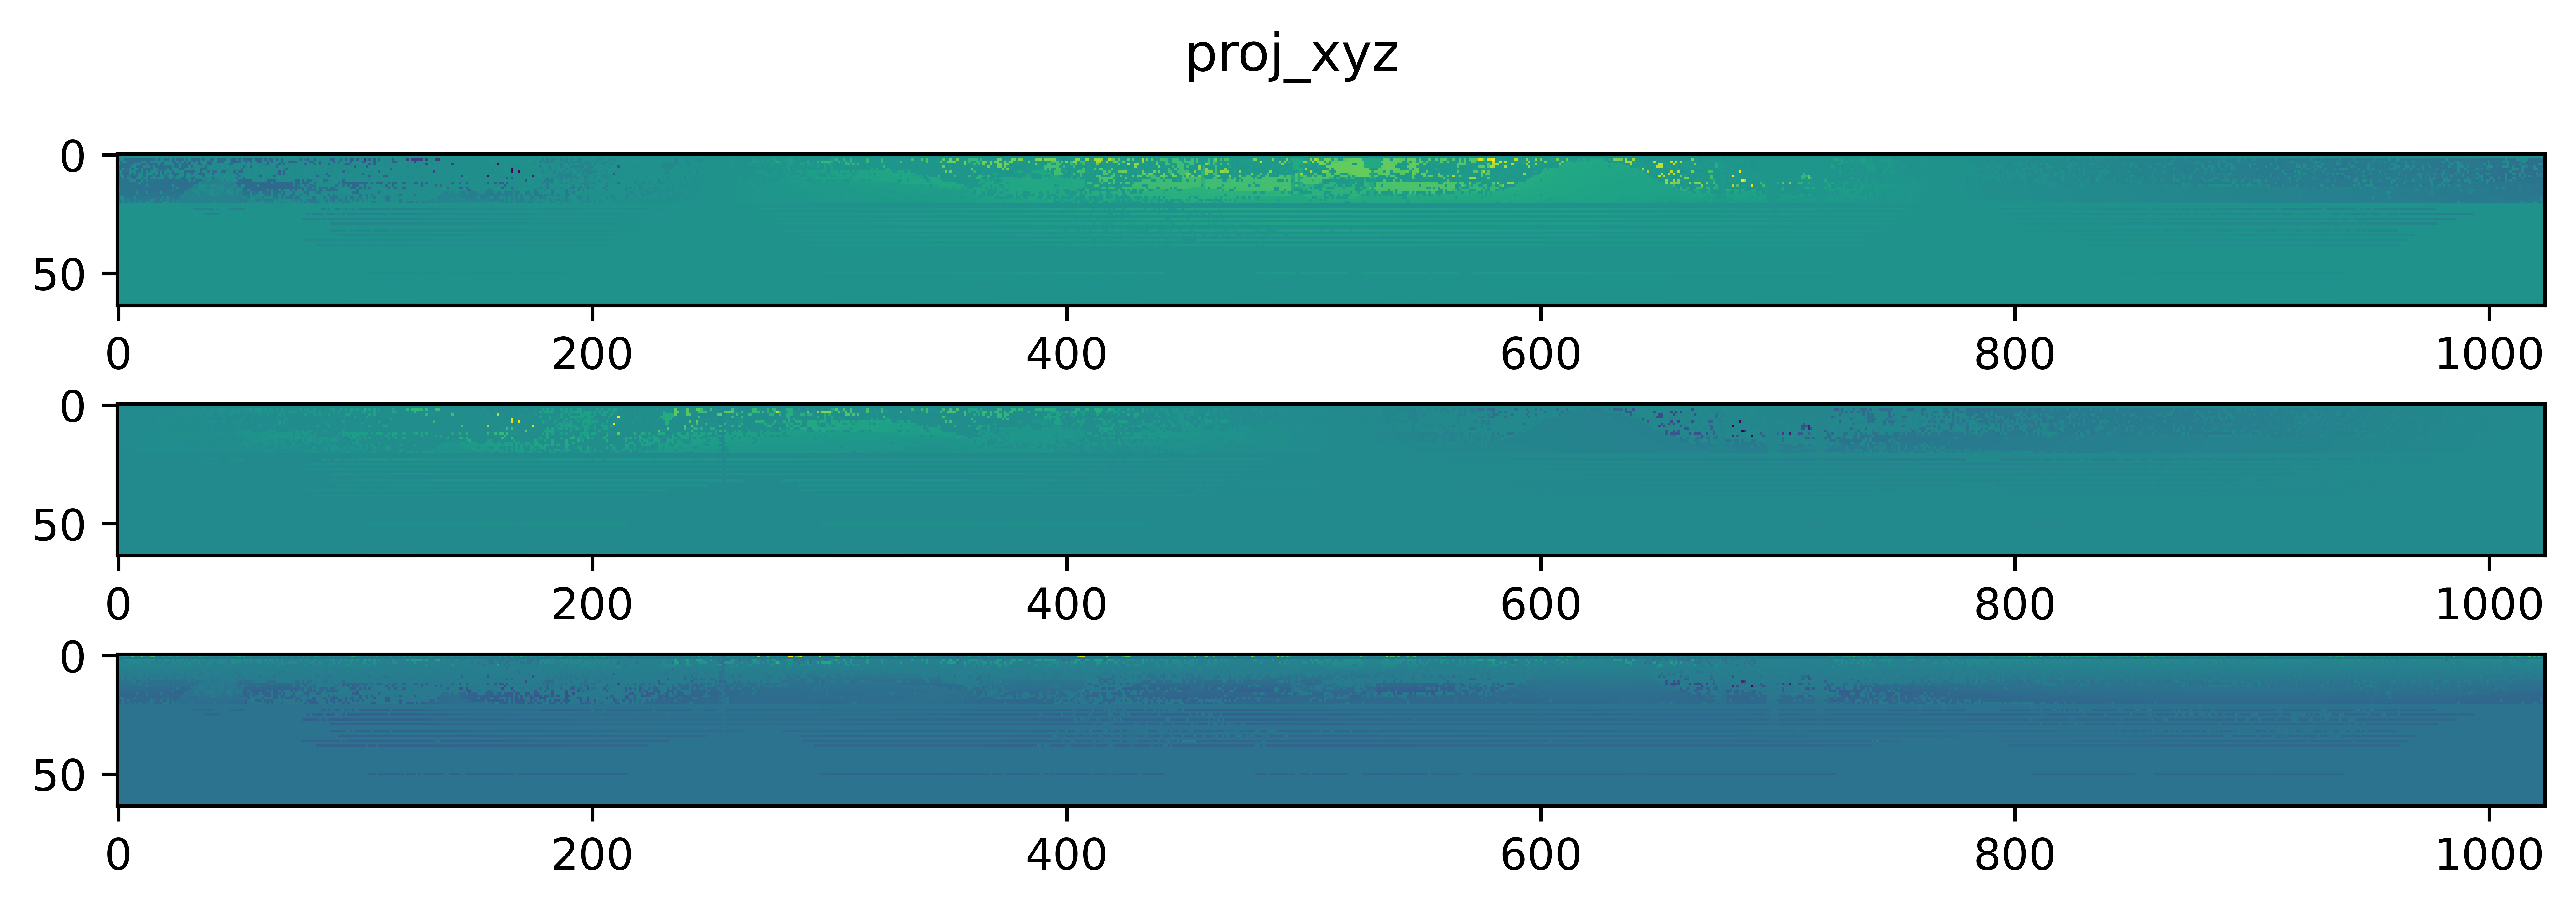

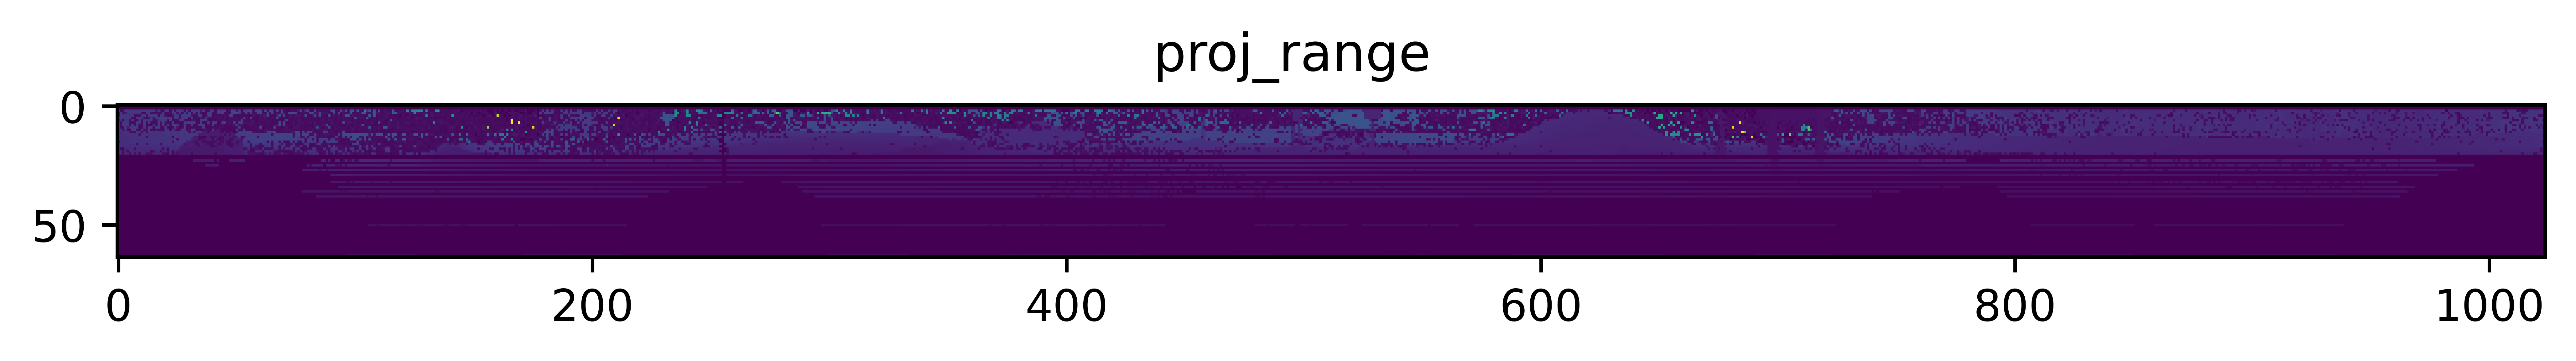

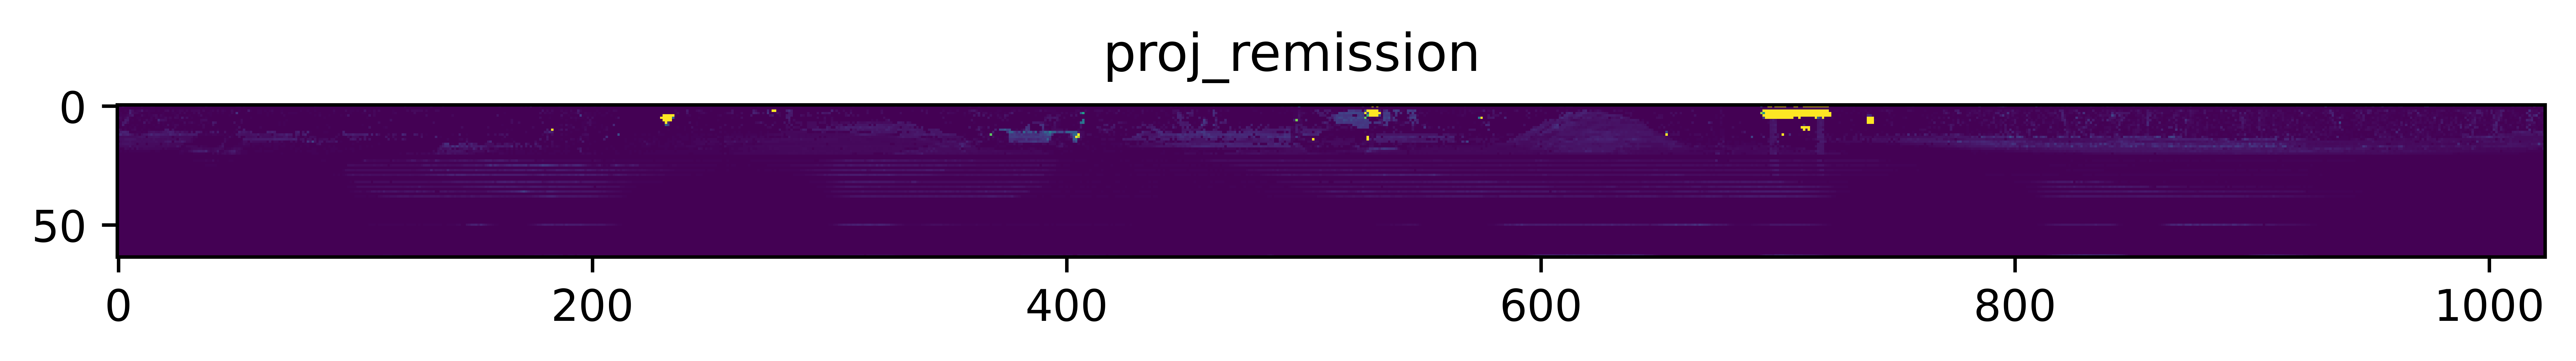

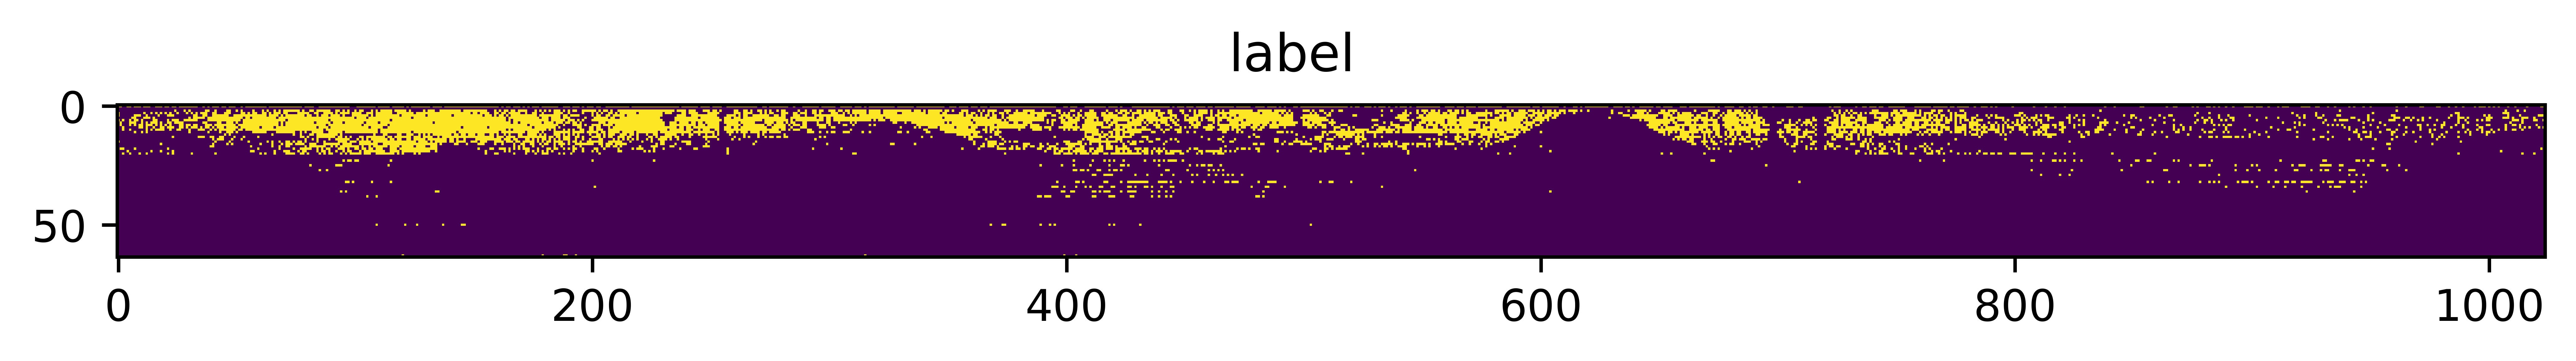

In [6]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 3), dpi=1000)
for i in range(3):
    axes[i].imshow(proj_xyz[i, :, :])
fig.suptitle("proj_xyz")

fig, ax = plt.subplots(figsize=(10, 1), dpi=1000)
ax.imshow(torch.squeeze(proj_range))
fig.suptitle("proj_range")

fig, ax = plt.subplots(figsize=(10, 1), dpi=1000)
ax.imshow(torch.squeeze(proj_remission))
fig.suptitle("proj_remission");

fig, ax = plt.subplots(figsize=(10, 1), dpi=1000)
ax.imshow(torch.squeeze(label))
fig.suptitle("label");

# Model and Training

In [7]:
hparams = {'train_ds': train_ds,
           'valid_ds': valid_ds,
           'test_ds': test_ds,
           'train_batch_size': 4,
           'valid_batch_size': 2,
           'test_batch_size': 2,
           'num_workers': 20
          }

train_dataloader = WADSLoader(**hparams).train_dataloader()
valid_dataloader = WADSLoader(**hparams).validation_dataloader()
test_dataloader = WADSLoader(**hparams).test_dataloader()

proj_xyz, proj_range, proj_remission, label = next(iter(train_dataloader))

print(proj_xyz.shape)
print(proj_range.shape)
print(proj_remission.shape)
print(label.shape)

torch.Size([4, 3, 64, 1024])
torch.Size([4, 1, 64, 1024])
torch.Size([4, 1, 64, 1024])
torch.Size([4, 1, 64, 1024])


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model =  WeatherNet(num_classes=1)

# Multi-GPU Training
model= nn.DataParallel(model)

model.to(device);

In [9]:
optimizer = Adam(model.parameters(), lr=0.3)
criterion = nn.BCELoss()
writer = SummaryWriter()
scheduler = ExponentialLR(optimizer, gamma=0.999)
sigmoid = nn.Sigmoid()

In [10]:
epochs = 200
train_ious = []
valid_ious = []
train_losses = []
valid_losses = []
best_loss = 100
best_iou = 0
saved = False

for epoch in range(epochs):
    print(Fore.YELLOW + f"Epoch: {(epoch+1):02}/{epochs}")
    for step, (proj_xyz, proj_range, proj_remission, label) in enumerate(train_dataloader):
        # Use weighted BCE for class imbalance: weight = sqrt(frequency)
        label_0_freq = (label == 0).sum().item()
        label_1_freq = (label == 1).sum().item()
        weight = torch.where(label == 0, 1/label_0_freq**0.5, 1/label_1_freq**0.5).to(device)
        criterion.weight = weight
        
        output = model(proj_range.to(device), proj_remission.to(device))
        output = sigmoid(output)
        pred = torch.where(output>=0.5, 1, 0)
        loss = criterion(output.float().to(device), label.float().to(device))
        iou = jaccard_index(label.cpu(), pred.cpu(), num_classes=2)
        
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()
        
        train_losses.append(loss.item())
        train_ious.append(iou.item())
        
        if (step % 50 == 0) or (step == len(train_dataloader)):
            train_loss = sum(train_losses)/len(train_losses)
            train_iou = sum(train_ious)/len(train_ious)
            writer.add_scalar('train_loss', train_loss, epoch * len(train_dataloader) + step)
            writer.add_scalar('train_iou', train_iou, epoch * len(train_dataloader) + step)
            train_losses.clear()
            train_ious.clear()
            
            model.eval() 
            with torch.no_grad():
                for proj_xyz, proj_range, proj_remission, label in valid_dataloader:
                    label_0_freq = (label == 0).sum().item()
                    label_1_freq = (label == 1).sum().item()
                    weight = torch.where(label == 0, 1/label_0_freq**0.5, 1/label_1_freq**0.5).to(device)
                    criterion.weight = weight

                    output = model(proj_range.to(device), proj_remission.to(device))
                    output = sigmoid(output)
                    pred = torch.where(output>=0.5, 1, 0)
                    loss = criterion(output.float().to(device), label.float().to(device))
                    iou = jaccard_index(label.cpu(), pred.cpu(), num_classes=2)
                    valid_losses.append(loss.item())
                    valid_ious.append(iou.item())
                
            valid_loss = sum(valid_losses)/len(valid_losses)
            valid_iou = sum(valid_ious)/len(valid_ious)
            writer.add_scalar('valid_loss', valid_loss, epoch * len(train_dataloader) + step)
            writer.add_scalar('valid_iou', valid_iou, epoch * len(train_dataloader) + step)
            valid_losses.clear()
            valid_ious.clear()
            
            if best_loss > valid_loss:
                best_loss = valid_loss
                best_model_loss = deepcopy(model.state_dict())
                saved = True
                
            if best_iou < valid_iou:
                best_iou = valid_iou
                best_model_iou = deepcopy(model.state_dict())
                saved = True
                
            if saved:
                print(Fore.GREEN + f"Training Loss(Accuracy): {train_loss:.6f}({train_iou*100:.2f}), Validation Loss(Accuracy): {valid_loss:.6f}({valid_iou*100:.2f})")
                saved = False
            else:
                print(Fore.RED + f"Training Loss(Accuracy): {train_loss:.6f}({train_iou*100:.2f}), Validation Loss(Accuracy): {valid_loss:.6f}({valid_iou*100:.2f})")

            model.train()
    
    scheduler.step()
    
    print(Fore.YELLOW + "=" * 74)

# Model Save and Load

In [11]:
torch.save(best_model_loss, "Best Model/best_model_loss.pt")
torch.save(best_model_iou, "Best Model/best_model_iou.pt")

In [19]:
model.load_state_dict(torch.load("Best Model/best_model_iou.pt"))

<All keys matched successfully>

# Quantitative Evaluation

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate(model, dataloader):
    losses = []
    ious = []
    preds = []
    labels = []
    preds_flatten = []
    labels_flatten = []
    
    model.eval() 
    with torch.no_grad():
        for proj_xyz, proj_range, proj_remission, label in dataloader:
            label_0_freq = (label == 0).sum().item()
            label_1_freq = (label == 1).sum().item()
            weight = torch.where(label == 0, 1/label_0_freq**0.5, 1/label_1_freq**0.5).to(device)
            criterion.weight = weight

            output = model(proj_range.to(device), proj_remission.to(device))
            output = sigmoid(output)
            pred = torch.where(output>=0.5, 1, 0)
            loss = criterion(output.float().to(device), label.float().to(device))
            iou = jaccard_index(label.cpu(), pred.cpu(), num_classes=2)
            
            preds.append(pred.cpu())
            labels.append(label.cpu())
            
            losses.append(loss.item())
            ious.append(iou.item())

    loss = sum(losses)/len(losses)
    iou = sum(ious)/len(ious)
    
    
    # Concatenate all predictions and labels
    preds = torch.concat(preds, dim=0)
    labels = torch.concat(labels, dim=0)
    
    # Flattening predictions and labels to feed to classification_report
    for i in range(labels.shape[0]):
        labels_flatten.append(labels[i].squeeze().flatten())
        preds_flatten.append(preds[i].squeeze().flatten())
    
    # Concatenate all flattened predictions and labels
    preds_flatten = torch.concat(preds_flatten, dim=0)
    labels_flatten = torch.concat(labels_flatten, dim=0)
    
    # Print classification report and plot confusion matrix
    print(classification_report(labels_flatten, preds_flatten, labels=[0, 1]))
    cm = confusion_matrix(labels_flatten, preds_flatten, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(xticks_rotation=45);
    
    return iou, loss, labels, preds

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   6073778
           1       0.97      0.86      0.91    610894

    accuracy                           0.98   6684672
   macro avg       0.98      0.93      0.95   6684672
weighted avg       0.98      0.98      0.98   6684672

Validation IoU: 91.14%


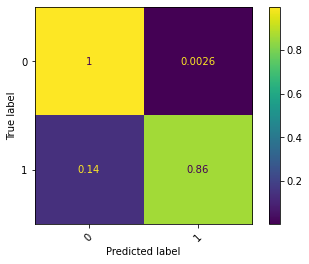

In [20]:
valid_iou, loss, labels, preds = evaluate(model, valid_dataloader)
print(f"Validation IoU: {valid_iou*100:.2f}%")

              precision    recall  f1-score   support

           0       0.99      1.00      0.99  24712510
           1       0.96      0.86      0.91   2157250

    accuracy                           0.99  26869760
   macro avg       0.98      0.93      0.95  26869760
weighted avg       0.99      0.99      0.99  26869760

Test IoU: 91.09%


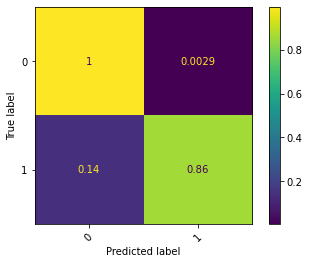

In [21]:
test_iou, loss, labels, preds = evaluate(model, test_dataloader)
print(f"Test IoU: {test_iou*100:.2f}%")

# Qualitative Evaluation 

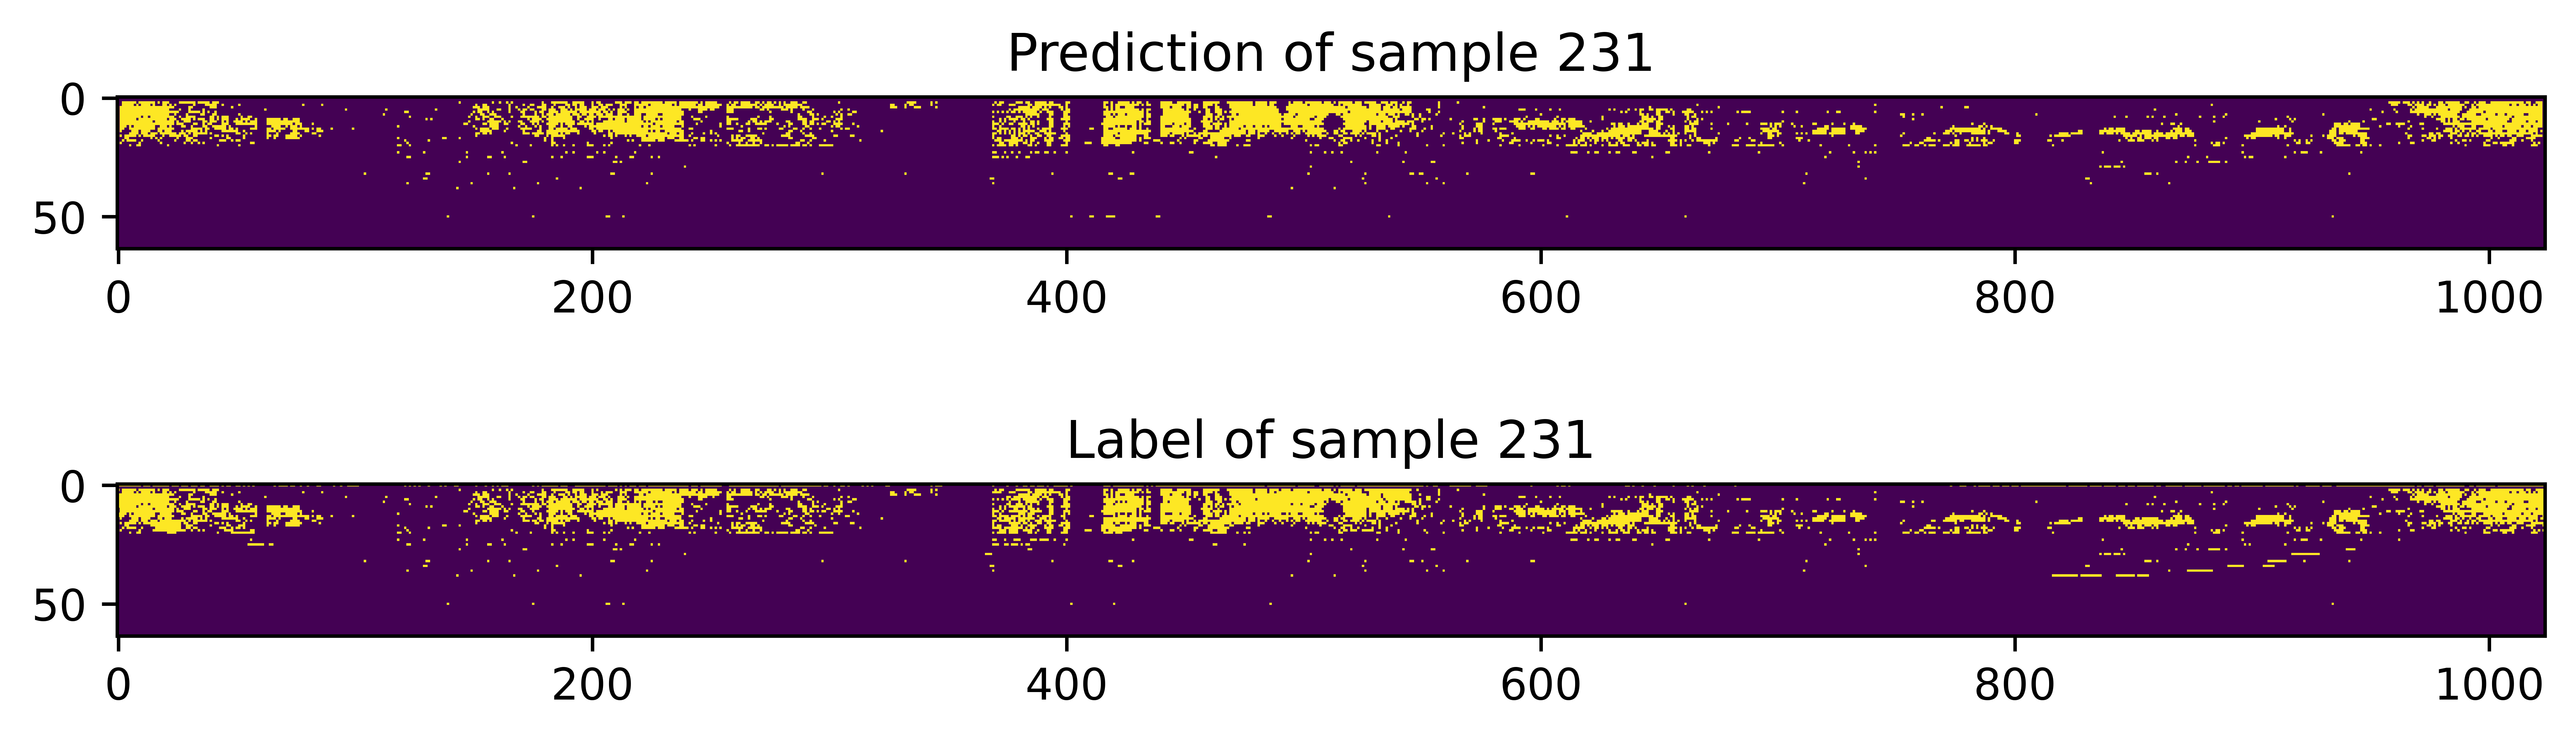

In [25]:
# Select a random rample for evaluation
idx = randint(0, labels.shape[0])

fig, axes = plt.subplots(figsize=(10,3), nrows=2, dpi=1000)
axes[0].imshow(preds[idx].cpu().squeeze())
axes[0].set_title(f"Prediction of sample {idx}");

axes[1].imshow(labels[idx].cpu().squeeze())
axes[1].set_title(f"Label of sample {idx}");